In [1]:
from dask_ml.metrics import mean_squared_error
import xarray as xr
import sklearn
from run_map import read_dask
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask.array as da
import dask.dataframe as dd

In [2]:
# paths
path_as = 'predictions/{year}/14246832_2022110313584614_{rep}'
reps = range(0, 30)

path_fluxcom = 'data/fluxcom_v006/rs/monthly/GPP.RS_V006.FP-ALL.MLM-ALL.METEO-NONE.4320_2160.monthly.{year}.nc'
path_fluxsat = 'data/fluxsat/FluxSat/GPP_FluxSat_daily_v2_{year}{month}.nc4'
path_trendy = ''

start_date = datetime.strptime('01-2001', '%m-%Y')
end_date = datetime.strptime('01-2020', '%m-%Y')

In [3]:
# load as
ds_as = []
for date in pd.date_range(start_date, end_date, freq='Y'):
    ds_as_y = []
    for rep in reps:
        ds_as_y.append(xr.open_dataset(path_as.format(year=date.year, rep=rep), chunks='auto', engine='zarr'))
        
    ds_as.append(xr.concat(ds_as_y, dim='rep'))
ds_as = xr.concat(ds_as, dim='time')
ds_as = ds_as.mean(dim='rep')
ds_as = ds_as.rename({'y': 'lat', 'x': 'lon'})
ds_as

<xarray.Dataset>
Dimensions:  (time: 228, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2019-12-31
  * lon      (lon) float64 -180.0 -179.7 -179.5 -179.2 ... 179.3 179.5 179.8
  * lat      (lat) float64 -89.97 -89.72 -89.47 -89.22 ... 89.28 89.53 89.78
Data variables:
    GPP      (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>

In [4]:
# load fluxsat
ds_fs = []
for date in pd.date_range(start_date, end_date, freq='M'):
    try:
        ds_fs.append(xr.open_dataset(path_fluxsat.format(year=date.year, month="%02d" % (date.month,)), chunks='auto'))
    except:
        print(str(date) + ' not loaded')
    
ds_fs = xr.concat(ds_fs, dim='time')[['GPP']].resample(time='M').mean()
ds_fs

2001-06-30 00:00:00 not loaded


<xarray.Dataset>
Dimensions:  (lat: 3600, lon: 7200, time: 228)
Coordinates:
  * lat      (lat) float32 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2019-12-31
Data variables:
    GPP      (time, lat, lon) float32 dask.array<chunksize=(1, 1293, 2591), meta=np.ndarray>
Attributes:
    institution:  NASA Goddard Space Flight Center
    source:       MODIS MCD43C collection 6 reflectances calibrated using FLU...
    comment:      any errors in input data sets will be reflected in this pro...
    Conventions:  CF-1.6
    title:        FluxSat gridded GPP
    references:   Joiner, J., and Y. Yoshida. 2020. Satellite-based reflectan...

In [5]:
# load fluxcom
ds_fc = []
for date in pd.date_range(start_date, end_date, freq='Y'):
    ds_fc.append(xr.open_dataset(path_fluxcom.format(year=date.year), chunks='auto'))
    
ds_fc = xr.concat(ds_fc, dim='time')[['GPP']].resample(time='M').mean()
ds_fc

<xarray.Dataset>
Dimensions:  (time: 228, lat: 2160, lon: 4320)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 89.96 89.87 89.79 89.71 ... -89.79 -89.88 -89.96
  * time     (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2019-12-31
Data variables:
    GPP      (time, lat, lon) float32 dask.array<chunksize=(1, 1447, 2896), meta=np.ndarray>
Attributes: (12/15)
    Comment:                      Ensemble median of 18 members
    Flux_Partitioning_FP:         NT, DT
    Machine_Learning_Method_MLM:  RF, ANN, MARS, GMDH, KRR, MTE, MTEV, MTEM, SVM
    Version:                      v1
    SETUP:                        RS_V006
    TYPE:                         ensemble
    ...                           ...
    Reference:                    Tramontana et al. 2016 - doi:10.5194/bg-13-...
    Institution:                  MPI-BGC-BGI
    Provided_By:                  Martin Jung [mjung@bgc-jena.mpg.de] on beha...
    Created_By:                   Fabian Gans [fgans@bgc-jena.mpg.de], Ulrich...
    Temporal_Aggregation_Method:  first interpolate to daily,  second aggrega...
    History:                      created: Wed Aug 21 11:15:57 2019

In [6]:
# load land-sea mask and vegetation mask
veg_mask_path = '/global/scratch/users/yanghuikang/upscale/data/processed/utility/mcd12c1_veg_mask'
veg_mask = xr.open_zarr(veg_mask_path,consolidated=False)
veg_mask = veg_mask.rename({'veg_mask': 'GPP', 'x': 'lon', 'y': 'lat'})
veg_mask = veg_mask.interp(coords={'lon': ds_as['lon'], 'lat': ds_as['lat']}, method='nearest')
veg_mask = veg_mask > 0

lsm_path = '/global/scratch/users/yanghuikang/upscale/data/processed/utility/lsm_1279l4_0.1x0.1.grb_v4_unpack.nc'
lsm = xr.open_dataset(lsm_path,engine='netcdf4')
lsm = lsm.rename({'longitude':'lon','latitude':'lat'})
lsm = lsm.rename({'lsm': 'GPP'})
lsm = lsm.squeeze('time').drop_vars(['time'])
lsm = lsm > 0

# adjust x axis from 0-360 to -180-180
lsm.coords['lon'] = (lsm.coords['lon'] + 180) % 360 - 180
lsm = lsm.sortby(lsm.lon)
lsm = lsm.interp(coords={'lon': ds_as['lon'], 'lat': ds_as['lat']}, method='nearest')

comb = lsm * veg_mask
comb

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 720)
Coordinates:
  * lon      (lon) float64 -180.0 -179.7 -179.5 -179.2 ... 179.3 179.5 179.8
  * lat      (lat) float64 -89.97 -89.72 -89.47 -89.22 ... 89.28 89.53 89.78
Data variables:
    GPP      (lat, lon) bool dask.array<chunksize=(720, 1440), meta=np.ndarray>

In [7]:
# randomly sample coordinates (only non-NaN locations)
n = 5000

# this samples locations where at least one GPP values is not NaN
ds_nonnan = comb.stack(loc=['lat', 'lon']).to_dask_dataframe()
ds_nonnan = ds_nonnan[ds_nonnan.GPP]

# weighted by latitude to represent the areas
weights = np.cos(np.deg2rad(ds_nonnan.lat))
loc_s = ds_nonnan.loc[np.random.choice(ds_nonnan.index, n, p=weights/np.sum(weights)), ['lat', 'lon']]
lat_s = xr.DataArray(loc_s['lat'], dims='loc')
lon_s = xr.DataArray(loc_s['lon'], dims='loc')

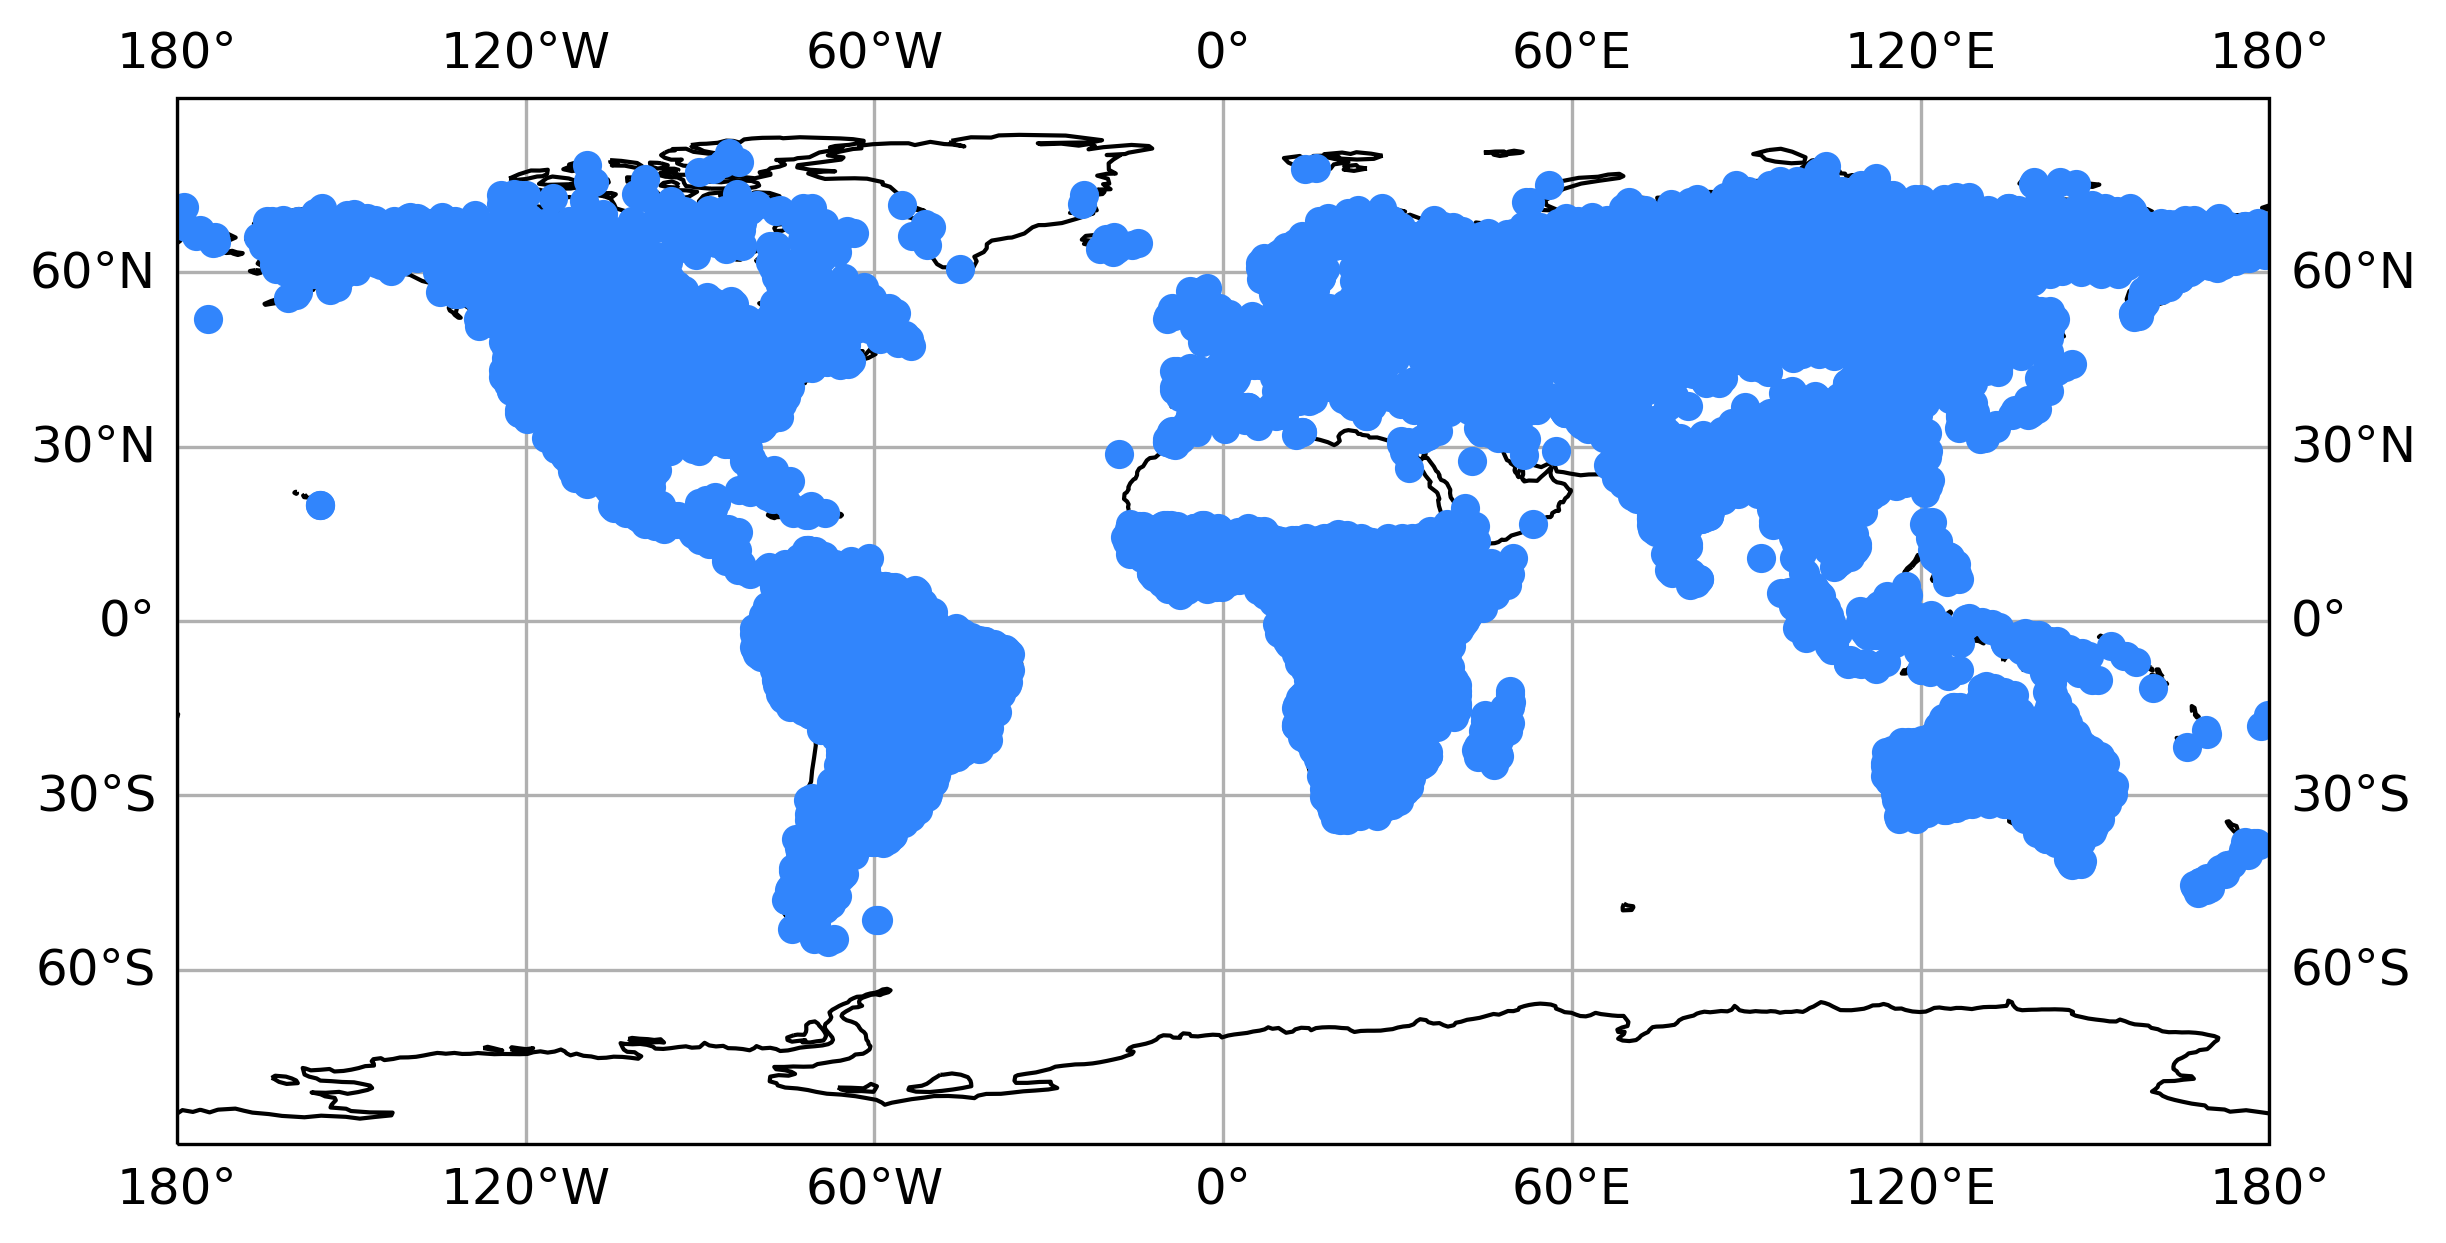

In [8]:
fig = plt.figure(figsize=(9, 7))
crs = ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_global()
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, zorder=0)
ax.coastlines(zorder=1)
ax.scatter(x=loc_s['lon'], y=loc_s['lat'])
#plt_im = lsm['GPP'].where(lsm['GPP'] > 0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, rasterized=True)

In [8]:
# sub-sample datasets
ds_as_s = ds_as.sel(lat=lat_s, lon=lon_s, method='nearest')
ds_fc_s = ds_fc.sel(lat=lat_s, lon=lon_s, method='nearest')
ds_fs_s = ds_fs.sel(lat=lat_s, lon=lon_s, method='nearest')

# change coordinates to sample coordinates
ds_as_s['lat'] = lat_s
ds_as_s['lon'] = lon_s
ds_as_s = ds_as_s.rename({'GPP': 'GPP_as'})
ds_fc_s['lat'] = lat_s
ds_fc_s['lon'] = lon_s
ds_fc_s = ds_fc_s.rename({'GPP': 'GPP_fc'})
ds_fs_s['lat'] = lat_s
ds_fs_s['lon'] = lon_s
ds_fs_s = ds_fs_s.rename({'GPP': 'GPP_fs'})

In [9]:
ds = xr.merge([ds_as_s, ds_fc_s, ds_fs_s]).unify_chunks()
df = ds.to_dask_dataframe()
df

,time,loc,lon,lat,GPP_as,GPP_fc,GPP_fs
npartitions=228,,,,,,,
0,datetime64[ns],int64,float64,float64,float32,float32,float32
5000,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
1135000,...,...,...,...,...,...,...
1139999,...,...,...,...,...,...,...


In [10]:
# calc evaluation metrices (RMSE)
def rmse(x, gt_col, pred_col):
    return ((x[pred_col] - x[gt_col])**2).mean() ** 0.5

def r2(x, gt_col, pred_col):
    return 1 - ((x[gt_col] - x[pred_col])**2).sum() / ((x[gt_col] - x[gt_col].mean())**2).sum()

df_r2 = df.groupby('loc').apply(r2, 'GPP_fc', 'GPP_as', meta=pd.Series(dtype=float))

In [ ]:
dd.to_csv(df_r2, 'analysis/ds_comparison/14246832_2022110313584614/r2_fc.csv', single_file=True)

In [ ]:
def draw_hist(x_vals, 
              n_bins, 
              rng=None, 
              x_fit=None, 
              fit_func=None,
              fit_params={},
              fit_scale=False,
              errs=False, 
              fit_info=None,
              ax=None, 
              fit_color='red', 
              hist_color='black',
              hist_alpha=.4,
              fit_label='Fitted curve',
              hist_label='Histogram',
              x_label='Value',
              legend=True, 
              **kwargs):
    '''Draws a histogram

    Args:
        x_vals (array): Values to be binned
        n_bins (int): Number of bins
        rng (tuple): Minimum and maximum x value
        x_fit (array): Array of fitted x values
        fit_func (array): Fitting function
        fit_params (dict): Fitting parameters
        errs (bool): Errorbars on histogram
        fit_info (list): List of fit info for chart legend
        ax (matplotlib.axis): Axis object

    Returns:
        matplotlib axis object

    TODO:
        scaling factor N?
    '''
    plot = False
    if ax is None:
        plot = True
        fig, ax = plt.subplots(figsize=(10, 5))

    # histogram
    n_hist, x_loc, _ = ax.hist(x_vals, bins=n_bins, range=rng, label=hist_label, color=hist_color, alpha=hist_alpha)

    print(np.sum(n_hist))

    # normalize with N_points * binwidth
    # binwidth = (xmax - xmin) / n_bins
    binwidth = np.abs(np.max(x_loc) - np.min(x_loc[0]))/n_bins
    #binwidth = np.abs(x_loc[1] - x_loc[0])
    n_points = len(x_vals)
    N = n_points * binwidth
    x_loc = (x_loc + binwidth/2)[:-1]

    # plot scatter and error bars
    if errs:
        ax.errorbar(x_loc, n_hist, yerr=np.sqrt(n_hist), ls='None', capsize=3, color=hist_color)

    # curve
    if fit_func is not None:
        if x_fit is None:
            x_fit = np.linspace(x_loc[0], x_loc[-1], 1000)

        ax.plot(x_fit, (fit_scale * N + 1 - fit_scale) * fit_func(x_fit, **fit_params), label=fit_label, color=fit_color)


    ax.set(xlabel=x_label, ylabel="Frequency / " + str(np.around(binwidth, 3)), **kwargs)

    if legend:
        leg_title = ''
        if fit_info is not None:
            leg_title = "\n".join(fit_info)
        ax.legend(title=leg_title)

    if plot == False:
        return ax
    else:
        plt.show()